# Customer Churn – Exploratory Data Analysis (EDA)

This notebook explores the Telco Customer Churn dataset and aims to understand
the data distribution, churn ratio, and key variables related to customer attrition.
1. Data loading & basic info
2. Global feature overview (describe, heatmap)
3. Categorical Feature Screening
4. Churn distribution
5. Churn-oriented feature analysis


## Data loading & basic info

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)


In [3]:
DATA_PATH = "../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

df.head()



,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape


(7043, 21)

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df.describe()


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## Global Feature Overview

Before focusing on churn-specific analysis, we first examine the overall
distribution and relationships among numerical features to understand
their scale, skewness, and potential correlations.


In [7]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


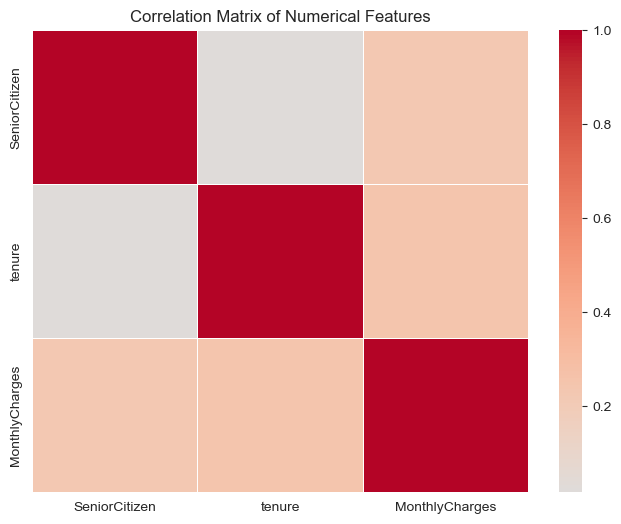

In [16]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(8,6))
corr = df[num_cols].corr()

sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)

plt.title("Correlation Matrix of Numerical Features")
plt.show()



In [17]:
from scipy.stats import chi2_contingency

cat_cols = (
    df.select_dtypes(include=["object", "bool"])
      .columns
      .drop(["customerID", "Churn"], errors="ignore")
)

chi2_results = []

for col in cat_cols:
    contingency = pd.crosstab(df[col], df["Churn"])
    chi2, p_value, _, _ = chi2_contingency(contingency)

    chi2_results.append({
        "feature": col,
        "p_value": p_value
    })

cat_screening = (
    pd.DataFrame(chi2_results)
      .sort_values("p_value")
      .reset_index(drop=True)
)

cat_screening


,feature,p_value
0,Contract,5.863038e-258
1,OnlineSecurity,2.661150e-185
2,TechSupport,1.443084e-180
3,InternetService,9.571788e-160
4,PaymentMethod,3.682355e-140
5,OnlineBackup,2.079759e-131
6,DeviceProtection,5.505219e-122
7,StreamingMovies,2.667757e-82
8,StreamingTV,5.528994e-82
9,PaperlessBilling,4.073355e-58


In [19]:
from scipy.stats import mannwhitneyu

num_results = []

for col in num_cols:
    x0 = df[df["Churn"] == "No"][col]
    x1 = df[df["Churn"] == "Yes"][col]

    _, p_value = mannwhitneyu(x0, x1, alternative="two-sided")

    num_results.append({
        "feature": col,
        "type": "numerical",
        "p_value": p_value
    })


In [20]:
cat_results = []

for col in cat_cols:
    contingency = pd.crosstab(df[col], df["Churn"])
    _, p_value, _, _ = chi2_contingency(contingency)

    cat_results.append({
        "feature": col,
        "type": "categorical",
        "p_value": p_value
    })


In [21]:
screening_df = pd.DataFrame(num_results + cat_results)\
                .sort_values("p_value")

screening_df


,feature,type,p_value
15,Contract,categorical,5.863038e-258
1,tenure,numerical,2.419636e-208
9,OnlineSecurity,categorical,2.661150e-185
12,TechSupport,categorical,1.443084e-180
8,InternetService,categorical,9.571788e-160
17,PaymentMethod,categorical,3.682355e-140
10,OnlineBackup,categorical,2.079759e-131
11,DeviceProtection,categorical,5.505219e-122
14,StreamingMovies,categorical,2.667757e-82
13,StreamingTV,categorical,5.528994e-82


## Feature Screening: Statistical Evidence for Feature Selection

To avoid subjective feature selection, we perform univariate statistical screening
on all available features to assess their association with customer churn.
This screening step serves as the primary evidence for selecting variables for
deeper exploratory analysis.


In [22]:
from scipy.stats import chi2_contingency, mannwhitneyu

screening_results = []

# Numerical features
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

for col in num_cols:
    x0 = df[df["Churn"] == "No"][col]
    x1 = df[df["Churn"] == "Yes"][col]

    _, p_value = mannwhitneyu(x0, x1, alternative="two-sided")

    screening_results.append({
        "feature": col,
        "type": "numerical",
        "p_value": p_value
    })

# Categorical features
cat_cols = (
    df.select_dtypes(include=["object", "bool"])
      .columns
      .drop(["customerID", "Churn"], errors="ignore")
)

for col in cat_cols:
    contingency = pd.crosstab(df[col], df["Churn"])
    _, p_value, _, _ = chi2_contingency(contingency)

    screening_results.append({
        "feature": col,
        "type": "categorical",
        "p_value": p_value
    })

screening_df = (
    pd.DataFrame(screening_results)
      .sort_values("p_value")
      .reset_index(drop=True)
)

screening_df


,feature,type,p_value
0,Contract,categorical,5.863038e-258
1,tenure,numerical,2.419636e-208
2,OnlineSecurity,categorical,2.661150e-185
3,TechSupport,categorical,1.443084e-180
4,InternetService,categorical,9.571788e-160
5,PaymentMethod,categorical,3.682355e-140
6,OnlineBackup,categorical,2.079759e-131
7,DeviceProtection,categorical,5.505219e-122
8,StreamingMovies,categorical,2.667757e-82
9,StreamingTV,categorical,5.528994e-82


Based on the screening results, we focus subsequent analysis on features with the
strongest statistical evidence, including:
- Contract
- InternetService
- OnlineSecurity / TechSupport
- tenure
- MonthlyCharges

These features are selected because they exhibit the strongest univariate
associations with churn and are also interpretable from a business perspective.


## Churn Distribution

Before analyzing individual features, we first examine the overall distribution
of the target variable. Understanding the churn ratio is essential for assessing
class imbalance and guiding subsequent modeling decisions.


In [23]:
df["Churn"].value_counts()


Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [24]:
df["Churn"].value_counts(normalize=True)


Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

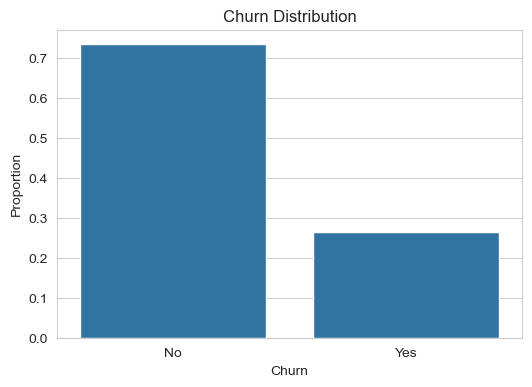

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

churn_counts = df["Churn"].value_counts(normalize=True).reset_index()
churn_counts.columns = ["Churn", "Proportion"]

sns.barplot(
    x="Churn",
    y="Proportion",
    data=churn_counts
)

plt.title("Churn Distribution")
plt.ylabel("Proportion")
plt.xlabel("Churn")
plt.show()


The dataset exhibits a clear class imbalance, with churned customers representing
approximately one quarter of the total population. This imbalance motivates the
use of evaluation metrics beyond accuracy and the application of resampling
techniques during model training.


## Churn-Oriented Feature Analysis

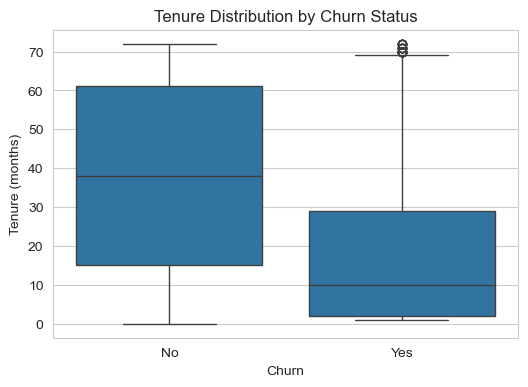

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    x="Churn",
    y="tenure",
    data=df
)

plt.title("Tenure Distribution by Churn Status")
plt.xlabel("Churn")
plt.ylabel("Tenure (months)")
plt.show()


In [26]:
from scipy.stats import mannwhitneyu

tenure_0 = df[df["Churn"] == "No"]["tenure"]
tenure_1 = df[df["Churn"] == "Yes"]["tenure"]

_, p_value = mannwhitneyu(tenure_0, tenure_1, alternative="two-sided")
p_value


np.float64(2.419635517951866e-208)

The tenure distributions of churned and non-churned customers differ significantly
(Mann–Whitney U test, p < 0.001), indicating that customers with shorter tenure are
more likely to churn.


In [10]:
contract_churn = (
    df.groupby("Contract")["Churn"]
      .value_counts(normalize=True)
      .rename("churn_rate")
      .reset_index()
)

contract_churn


,Contract,Churn,churn_rate
0,Month-to-month,No,0.572903
1,Month-to-month,Yes,0.427097
2,One year,No,0.887305
3,One year,Yes,0.112695
4,Two year,No,0.971681
5,Two year,Yes,0.028319


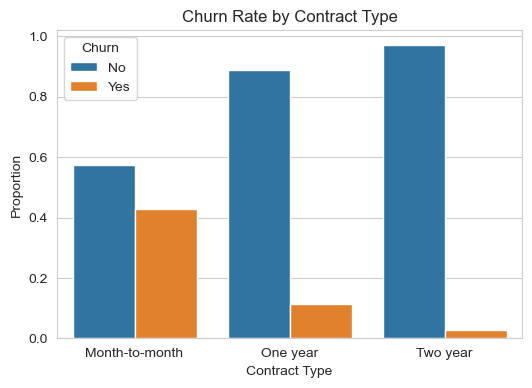

In [11]:
sns.barplot(
    x="Contract",
    y="churn_rate",
    hue="Churn",
    data=contract_churn
)

plt.title("Churn Rate by Contract Type")
plt.ylabel("Proportion")
plt.xlabel("Contract Type")
plt.show()


In [12]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df["Contract"], df["Churn"])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

p_value


np.float64(5.863038300673391e-258)

Churn rates vary substantially across contract types. Month-to-month contracts
exhibit the highest churn rate, and the association between contract type and churn
is statistically significant (chi-square test, p < 0.001).


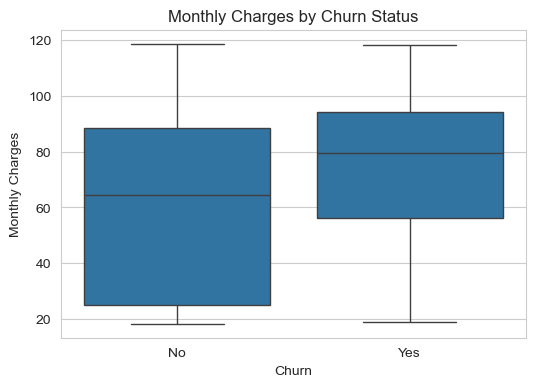

In [13]:
sns.boxplot(
    x="Churn",
    y="MonthlyCharges",
    data=df
)

plt.title("Monthly Charges by Churn Status")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges")
plt.show()


In [14]:
charges_churn_0 = df[df["Churn"] == "No"]["MonthlyCharges"]
charges_churn_1 = df[df["Churn"] == "Yes"]["MonthlyCharges"]

stat, p_value = mannwhitneyu(
    charges_churn_0,
    charges_churn_1,
    alternative="two-sided"
)

p_value


np.float64(3.311627651988585e-54)

Monthly charges differ significantly between churned and non-churned customers
(Mann–Whitney U test, p < 0.001), suggesting that higher pricing is associated
with increased churn risk.


## EDA Summary

I first conducted a global overview of numerical features
to assess scale, skewness, and correlations, revealing heterogeneous distributions
and strong correlations among charge-related variables.

Next, univariate statistical feature screening was performed on all numerical and
categorical features to objectively assess their association with churn. Numerical
features were evaluated using the Mann–Whitney U test, while categorical features
were assessed using the chi-square test. This screening step serves as the primary
evidence for feature selection in subsequent analysis.

The screening results indicate that contract type, internet-related services
(e.g., online security and technical support), tenure, and monthly charges exhibit
the strongest statistical associations with churn. In contrast, features such as
gender and basic phone services show weak or non-significant associations and were
excluded from deeper exploratory analysis.

Analysis of the target distribution shows a clear class imbalance, with churned
customers representing approximately one quarter of the dataset. This imbalance
motivates the use of appropriate evaluation metrics and resampling techniques in
later modeling stages.

Focused churn-oriented analysis of the selected features reveals consistent and
interpretable patterns. Customers with shorter tenure are significantly more likely
to churn, month-to-month contracts exhibit substantially higher churn rates than
longer-term contracts, and churned customers tend to have higher monthly charges.
Additionally, the absence of value-added internet services is strongly associated
with increased churn risk.

Overall, the EDA provides a coherent evidence base for model selection and feature
engineering decisions. The findings support the use of supervised learning models
that can capture both linear effects (e.g., tenure and pricing) and categorical
structure (e.g., contract and service subscriptions), while accounting for class
imbalance in churn prediction.